# Imports

In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Utilities

In [47]:
def imshow(im):
    width, height, *channels = im.shape
    if channels:
        # By default, OpenCV tends to work with images in the BGR format.
        # This is due to some outdated practices, but it has been left in the library.
        # We can iterate the channels in reverse order to get an RGB image.
        plt.imshow(im[:,:,::-1])
    else:
        plt.imshow(im, cmap='gray')
    plt.axis('off')

In [48]:
def reorder(vertices):
    # OpenCV *prefers* if we use `np.float32`.
    reordered = np.zeros_like(vertices, dtype=np.float32)
    add = vertices.sum(1)
    reordered[0] = vertices[np.argmin(add)]
    reordered[2] = vertices[np.argmax(add)]
    diff = np.diff(vertices, axis=1)
    reordered[1] = vertices[np.argmin(diff)]
    reordered[3] = vertices[np.argmax(diff)]
    return reordered

# Image

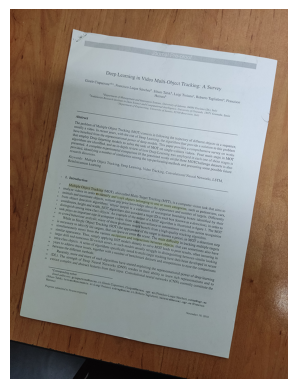

In [49]:
im = cv2.imread('images/example.jpg')
imshow(im)

# Process

Follow the hints in each section to implement the functions.

## Grayscale Transform

Use the `cv2.cvtColor` function with any color space you deem appropriate. The resulting image should have a single channel.

In [50]:
def to_grayscale(im):
    return cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

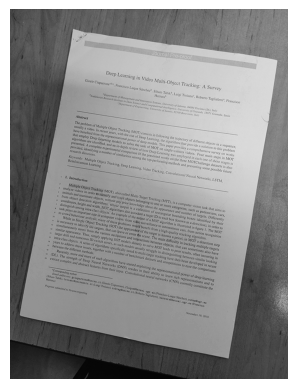

In [51]:
grayscale = to_grayscale(im)
imshow(grayscale)

## Blurring the Image

The Gaussian filter or its more advanced sibling, the Bilateral filter, have shown the best results. Go with whatever smoothing filter you prefer. Considering that the image is highly likely to contain texts, adjust your window size accordingly.

In [52]:
def blur(im):
    return cv2.GaussianBlur(im, (3, 3), 0)

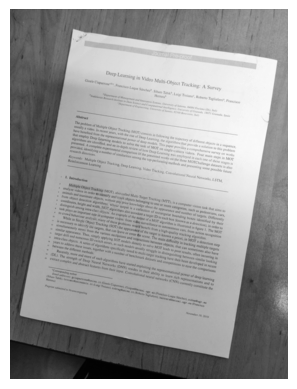

In [53]:
blurred = blur(grayscale)
imshow(blurred)

## Edge Detection

The `cv2.Canny` filter tends to generate the best results. Tune its thresholds using the provided image and try it on a few more examples.

In [54]:
def to_edges(im):
    edges = cv2.Canny(im, 50, 150)
    return edges

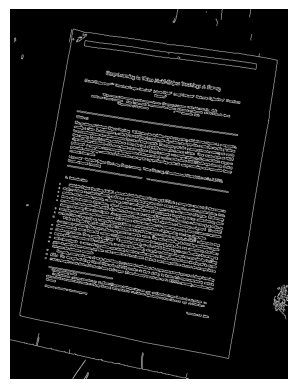

In [55]:
edges = to_edges(blurred)
imshow(edges)

## Contour Detection

We highly suggest that you learn more about [image contours](https://docs.opencv.org/4.x/d4/d73/tutorial_py_contours_begin.html), specifically, the `cv2.findContours` function. You'd want to find the contour that has the largest surface area (using `cv2.contourArea`) and simplify its boundaries to a quadrilateral using `cv2.approxPolyDP` (and possibly `cv2.arcLength`). If this all sounds too complicated, go with the Hough transform. As discussed in the instructions, you can use the Hough transform to identify four lines within the output of `to_edges` to identify the most prominent parallelogram present in the image. This isn't, however, the best solution.

Regardless of the method, the output of the function must be the coordinates of the four vertices containing the page, in the form of a `4x2` array.

*Hint*: If you are using `cv2.findContours`, the Simple Approximation Model suffices for our purposes.

In [56]:
def find_vertices(im):
    contours, _ = cv2.findContours(im.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
    
    vertices = None
    for cnt in contours:
        epsilon = 0.02 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        
        if len(approx) == 4:
            vertices = approx.reshape(4, 2)
            break

    if vertices is None:
        height, width = im.shape[:2]
        vertices = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype=np.float32)
    
    vertices = reorder(vertices)
    
    return vertices

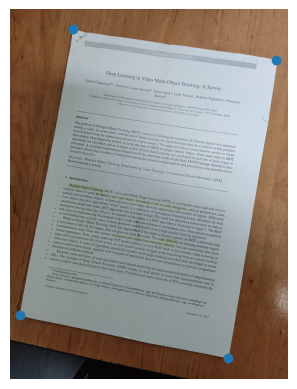

In [57]:
imshow(im)
vertices = find_vertices(edges)
plt.scatter([x for x, y in vertices], [y for x, y in vertices])

## Perspective Transform

We can use the `cv2.getPerspectiveTransform` function to find a transform that maps the region we have identified to a rectangle that we can easily crop. You then need to use `cv2.warpPerspective` to apply this transform and crop out the target region.

**Note**: `cv2.getPerspectiveTransform` expects your vertices in a particular order. They should be top left, top right, bottom right, and finally, bottom left. We have implemented a utility function for this purpose.

In [58]:
def crop_out(im, vertices):
    width = 600  
    height = 850 
    
    target = np.array([
        [0, 0],
        [width, 0],
        [width, height],
        [0, height]
    ], dtype=np.float32)
    
    transform = cv2.getPerspectiveTransform(vertices, target)

    cropped = cv2.warpPerspective(im, transform, (width, height))
    
    return cropped

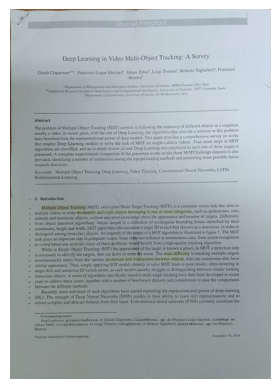

In [59]:
cropped = crop_out(im, vertices)
imshow(cropped)

## Image Enhancement

I'll leave this part up to you!

In [60]:
def enhance(im):
    # Mild color correction 
    gamma = 1.1
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                    for i in np.arange(0, 256)]).astype("uint8")
    corrected = cv2.LUT(im, table)

    # LAB Color Space
    lab = cv2.cvtColor(corrected, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    # Gentle CLAHE 
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(12, 12))
    l = clahe.apply(l)
    
    # Merge channels 
    lab = cv2.merge([l, a, b])
    enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    # Smart saturation boost
    hsv = cv2.cvtColor(enhanced, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    
    # Saturation mask 
    s_clean = cv2.bilateralFilter(s, 9, 75, 75)
    s = cv2.addWeighted(s, 1.2, s_clean, 0.3, 0)
    s = np.clip(s, 20, 230).astype(np.uint8)
    
    hsv = cv2.merge([h, s, v])
    enhanced = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # Controlled sharpening
    blurred = cv2.GaussianBlur(enhanced, (0, 0), 2.0)
    sharpened = cv2.addWeighted(enhanced, 1.5, blurred, -0.5, 0)

    # Noise reduction 
    final = cv2.bilateralFilter(sharpened, 9, 75, 75)
    return final

## Result

Let's put everything together and get the result in one go.

In [61]:
def scan(im):
    grayscale = to_grayscale(im)
    blurred = blur(grayscale)
    edges = to_edges(blurred)
    vertices = find_vertices(edges)
    cropped = crop_out(im, vertices)
    return enhance(cropped)

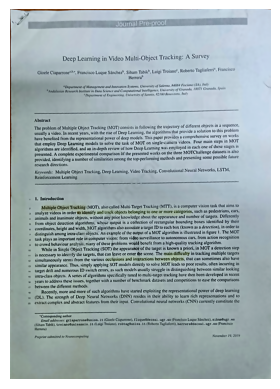

In [62]:
scanned = scan(im)
imshow(scanned)

In [63]:
cv2.imwrite('scanned.jpg', scanned)

True